### This notebook generates the moisture-precip relationships for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

## Loading ERA-I data

In [3]:
#How many precipitating versus non-precipitating MCSs? Roughly 40-50% each year.
#for i in np.arange( 1983, 2009 ):
#    o1 = xr.open_dataset('/groups/sylvia/JAS-MCS-rain/ERAI/colloc_' + str(i) + '.nc')['occurrence']
#    o2 = xr.open_dataset('/groups/sylvia/JAS-MCS-rain/ERAI/colloc_' + str(i) + '_NZ.nc')['occurrence']
#    print( len(o1), len(o2), len(o1)-len(o2), (len(o1)-len(o2))/len(o1)*100 )
#    print( '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~' )

#/xdisk/sylvia/MCS_clim/ausgabe/meteo_clim/nc/ERAI/colloc_1983_NZ.nc
display( xr.open_dataset('/groups/sylvia/JAS-MCS-rain/ERAI/colloc_1983_NZ.nc') )

<xarray.Dataset>
Dimensions:                     (altitude: 32, occurrence: 18082)
Dimensions without coordinates: altitude, occurrence
Data variables: (12/47)
    z                           (altitude) float32 ...
    pressure                    (altitude) float32 ...
    year                        (occurrence) int64 ...
    month                       (occurrence) int64 ...
    day                         (occurrence) int64 ...
    hour                        (occurrence) int64 ...
    ...                          ...
    tpre6                       (occurrence, altitude) float32 ...
    tpre9                       (occurrence, altitude) float32 ...
    surface latent heat flux    (occurrence) float32 ...
    surface sensible heat flux  (occurrence) float32 ...
    pmax                        (occurrence) float32 ...
    pacc                        (occurrence) float32 ...
Attributes:
    history:  Sat Dec 30 10:30:52 2023: ncrename -v w,omega colloc_1983_NZ.nc...
    NCO:      netCDF Operators version 5.0.4-alpha01 (Homepage = http://nco.s...

In [4]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
print(np.nanmin(minlat_array))
maxlat_array = nc_open_compile(file_years,"max latitude")
print(np.nanmax(maxlat_array))
tropical_indx = np.argwhere( (minlat_array >= -30) & (maxlat_array <= 30) )[:,0]
print(tropical_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_indx]

-56.0
56.0
(695667,)


In [5]:
# creating cape array from different files and treating for negatives
cape_array = nc_open_compile(file_years,"cape")
cape_ERAI = negative_to_nan(cape_array)[tropical_indx]
capepre_array = nc_open_compile(file_years,"capepre")
capepre_ERAI = negative_to_nan(capepre_array)[tropical_indx]
capepre6_array = nc_open_compile(file_years,"capepre6")
capepre6_ERAI = negative_to_nan(capepre6_array)[tropical_indx]

# applying same for pmax and pacc
pmax_array = nc_open_compile(file_years,"pmax")
pmax_ERAI = negative_to_nan(pmax_array)[tropical_indx]
pacc_array = nc_open_compile(file_years,"pacc")
pacc_ERAI = negative_to_nan(pacc_array)[tropical_indx]*3600 # convert to m3 / h

# extract pressure from the data files
# water vapour levels opened and vstacked, negatives removed
qv_array = nc_open_compile( file_years, "qv", 'stack' )
qv_ERAI = negative_to_nan(qv_array)[tropical_indx]
qvpre_array = nc_open_compile( file_years, "qvpre", 'stack' )
qvpre_ERAI = negative_to_nan(qvpre_array)[tropical_indx]
qvpre6_array = nc_open_compile( file_years, "qvpre6", 'stack' )
qvpre6_ERAI = negative_to_nan(qvpre6_array)[tropical_indx]

#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERAI = np.double((xr.open_dataset(file_years[0])).pressure.data)*100

In [6]:
# calculate the saturation vapor mixing ratio, Curry & Webster (4.37)
temp_ERAI = nc_open_compile( file_years, "temperature", 'stack' )[tropical_indx]
qvsat_ERAI = eps * satVapP_liq(temp_ERAI) / ( plev_ERAI - satVapP_liq(temp_ERAI) )

# as in Singh et al. 2017 we calculate saturation deficit as the arithmetic mean
# between its values at 850, 700, and 550 hPa
i = np.argmin( np.abs(plev_ERAI - 85000) )
sd850_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000   # 1000 converts [kg kg-1] to [g kg-1]
sd850pre_ERAI = (qvsat_ERAI[:,i] - qvpre_ERAI[:,i])*1000   # [g kg-1]
sd850pre6_ERAI = (qvsat_ERAI[:,i] - qvpre6_ERAI[:,i])*1000   # [g kg-1]

i = np.argmin( np.abs(plev_ERAI - 70000) )
sd700_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000
sd700pre_ERAI = (qvsat_ERAI[:,i] - qvpre_ERAI[:,i])*1000
sd700pre6_ERAI = (qvsat_ERAI[:,i] - qvpre6_ERAI[:,i])*100

i = np.argmin( np.abs(plev_ERAI - 55000) )
sd550_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000
sd550pre_ERAI = (qvsat_ERAI[:,i] - qvpre_ERAI[:,i])*1000
sd550pre6_ERAI = (qvsat_ERAI[:,i] - qvpre6_ERAI[:,i])*1000

sd_ERAI = (sd850_ERAI + sd700_ERAI + sd550_ERAI)/3
sdpre_ERAI = (sd850pre_ERAI + sd700pre_ERAI + sd550pre_ERAI)/3
sdpre6_ERAI = (sd850pre6_ERAI + sd700pre6_ERAI + sd550pre6_ERAI)/3

print( 'Min, Mean, and Max SD [g kg-1]: ' + str(np.nanmin(sd_ERAI)) + ' ' + str(np.nanmedian(sd_ERAI)) + ' ' + str(np.nanmax(sd_ERAI)) )

Min, Mean, and Max SD [g kg-1]: -8.195535603071171 2.9261935177338905 12.085021871113057


In [7]:
#integral computed using trapezoidal integration
integral_ERAI = np.trapz( x=plev_ERAI, y=qv_ERAI )

#integral computed using trapezoidal integration - assuming complete saturation in the column
integral_sat_ERAI = np.trapz( x=plev_ERAI, y=qvsat_ERAI )

#cwvc calculated, the factor of 1000 converts m to mm
cwvc_ERAI = integral_ERAI / (rho_water*g) * 1000
print( 'Min, Mean, and Max CWVC [mm]: ' + str(np.nanmin(cwvc_ERAI)) + ' ' + str(np.nanmean(cwvc_ERAI)) + ' ' + str(np.nanmax(cwvc_ERAI)) )

#csf calculated, multiply by 100 to convert to a %
csf_ERAI = integral_ERAI / integral_sat_ERAI * 100
print( 'Min, Mean, and Max CSF [%]: ' + str(np.nanmin(csf_ERAI)) + ' ' + str(np.nanmean(csf_ERAI)) + ' ' + str(np.nanmax(csf_ERAI)) )

Min, Mean, and Max CWVC [mm]: 0.5510099275241246 40.79797889288164 80.5948213973405
Min, Mean, and Max CSF [%]: 1.1126021228933392 70.21310787626841 523.160202634015


In [8]:
# create bins in cwvc and evaluate corresponding precipitation percentiles
cwvc_bins, pmax_vals, pmax_95_vals, pmax_99_vals, cwvc_error, pmax_error, cwvc_max, pmax_max = \
    bin_stat_function( 35, 5, 75, cwvc_ERAI, pmax_ERAI, threshold=100 )

# create bins in column saturation fraction and evaluate corresponding precipitation percentiles
csf_bins, pmax_vals2, pmax_95_vals2, pmax_99_vals2, csf_error, pmax_error2, csf_max, pmax_max2 = \
    bin_stat_function( 35, 0, 100, csf_ERAI, pmax_ERAI, threshold=100 )

# create bins in column saturation fraction and evaluate corresponding precip accumulation percentiles
csf_bins, pacc_vals2, pacc_95_vals2, pacc_99_vals2, csf_error, pacc_error2, csf_max, pacc_max2 = \
    bin_stat_function( 35, 0, 100, csf_ERAI, pacc_ERAI, threshold=100 )

# create bins for *positive* saturation deficits and evaluate corresponding CAPE percentiles
sd_bins, cape_vals, cape_95_vals, cape_99_vals, sd_error, cape_error, sd_max, cape_max = \
    bin_stat_function( 35, 0, 8, sd_ERAI, cape_ERAI, threshold=100 )

# create bins for saturation deficit and evaluate corresponding preceding CAPE percentiles
#sd_bins2, capepre_vals, capepre_95_vals, capepre_99_vals, sd_error2, capepre_error, sd_max2, capepre_max = \
#    bin_stat_function( 35, 0, 8, sd_ERAI, capepre_ERAI, threshold=10 )
#sd_bins3, capepre6_vals, capepre6_95_vals, capepre6_99_vals, sd_errore, capepre6_error, sd_max3, capepre6_max = \
#    bin_stat_function( 35, 0, 8, sd_ERAI, capepre6_ERAI, threshold=10 )

# create bins for preceding saturation deficit and evaluate corresponding preceding CAPE percentiles
sdpre_bins, capepre_vals2, capepre_95_vals2, capepre_99_vals2, sdpre_error, capepre_error2, sdpre_max, capepre_max2 = \
    bin_stat_function( 35, 0, 8, sdpre_ERAI, capepre_ERAI, threshold=100 )
sdpre6_bins, capepre6_vals2, capepre6_95_vals2, capepre6_99_vals2, sdpre6_error, capepre6_error2, sdpre6_max, capepre6_max2 = \
    bin_stat_function( 35, 0, 8, sdpre6_ERAI, capepre6_ERAI, threshold=100 )

## Figure 2 - Joint distribution of CSF and MCS precip intensity

In [9]:
def scatter_hist(x, y, xbins, ybins, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    h = ax.hist2d( x, y, bins=(xbins, ybins), cmap=cm.Blues )
    wgts = np.ones_like(x)/float(len(x))*100
    ax_histx.hist(x, bins=xbins, edgecolor='k', weights=wgts )
    ax_histx.tick_params(axis='both', which='major', labelsize=12)
    wgts = np.ones_like(y)/float(len(y))*100
    ax_histy.hist(y, bins=ybins, edgecolor='k', weights=wgts, orientation='horizontal')
    ax_histy.tick_params(axis='both', which='major', labelsize=12)
    ax_histy.set_yscale('log')
    return h

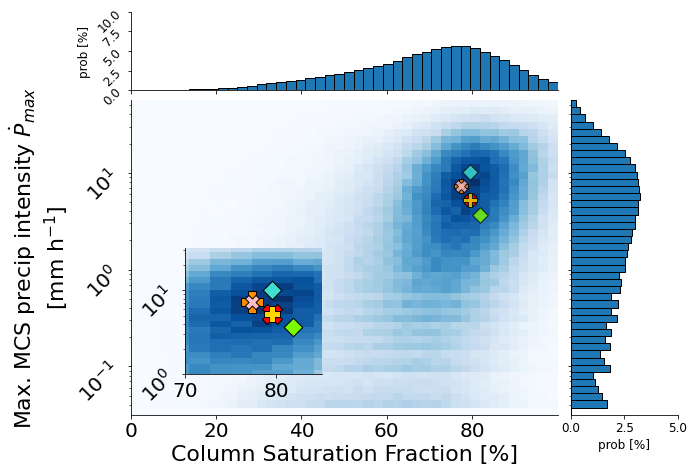

In [15]:
fig = plt.figure( figsize=(9.5, 7) )
font_size = 20
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})
i = np.where( (~np.isnan(csf_ERAI)) & (~np.isnan(pmax_ERAI)) )

gs = fig.add_gridspec( 2, 2, width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9,
                     wspace=0.05, hspace=0.05 )
ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot( gs[0,0], sharex=ax )
ax_histy = fig.add_subplot( gs[1,1], sharey=ax )
xbins = np.linspace( 0, 100, 45 )
ybins = np.logspace( -1.5, 1.75, 45 )
h = scatter_hist( csf_ERAI[i], pmax_ERAI[i], xbins, ybins, ax, ax_histx, ax_histy )

ax.set_xticks( [0, 20, 40, 60, 80] )
ax_histx.set_ylabel( 'prob [%]', fontsize=12 )
ax_histx.set_yticks( [0, 2.5, 5, 7.5, 10], rotation=45 )
ax_histy.set_xlabel( 'prob [%]', fontsize=12 )
ax_histy.set_xticks( [0, 2.5, 5], rotation=45 )
ax.set_ylabel( r'Max. MCS precip intensity $\dot{P}_{max}$ '
              '\n'
              '[mm h$^{-1}$]' )
ax.set_xlabel( 'Column Saturation Fraction [%]' )

# Inset to see centroids more easily
left, bottom, width, height = [0.18, 0.18, 0.2, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.hist2d( csf_ERAI[i], pmax_ERAI[i], bins=(xbins, ybins), cmap=cm.Blues )
ax2.set_xlim( [70, 85] )
ax2.set_yscale( 'log' )
ax2.set_ylim( [1, 10**1.5] )

for a in ax, ax_histx, ax_histy, ax2:
    a.spines['top'].set_visible( False )
    a.spines['right'].set_visible( False )
    for t in a.get_yticklabels():
        t.set_rotation(45)

        
# Where is the center of mass of the joint distribution for young/old/big/small systems? 
# (The cells below must be run for this.)
h_csfpmax = [ h1, h4, h5, h7, h3, h6 ] #h2 - already covered by h4, h6 - already covered by h5
farbe = [ 'red', 'gold', 'darkorange', 'lawngreen', 'pink', 'turquoise' ]
forme = [ 'X', 'P', 'P', 'D', 'X', 'D']
grose = [ 150, 200, 200, 120, 150, 120 ]
increment = [ 250, 40, 250, 50, 50, 50 ]
for histo, f, s, z, ii in zip( h_csfpmax, farbe, forme, grose, increment ):
    l, m = unravel_index( histo[0].argmax(), histo[0].shape )
    #print(l,m)
    ax.scatter( xbins[l], ybins[m], marker=s, color=f, s=z, zorder=10, edgecolor='k', alpha=0.8 )
    ax2.scatter( xbins[l], ybins[m], marker=s, color=f, s=z+ii, zorder=10, edgecolor='k' )
    
plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-precip-ERAI.pdf', bbox_inches='tight' )
plt.show()

### Joint distribution of CSF and MCS precip for short- and long-lived systems

In [11]:
i = np.where(lifetime_ERAI <= 2)
csf_ERAI_young = csf_ERAI[i]
pmax_ERAI_young = pmax_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_young)) & (~np.isnan(pmax_ERAI_young)) )
h1 = scatter_hist( csf_ERAI_young[i], pmax_ERAI_young[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where((lifetime_ERAI <= 4) & (lifetime_ERAI > 2))
csf_ERAI_mid = csf_ERAI[i]
pmax_ERAI_mid = pmax_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_mid)) & (~np.isnan(pmax_ERAI_mid)) )
h2 = scatter_hist( csf_ERAI_mid[i], pmax_ERAI_mid[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where((lifetime_ERAI > 3))
csf_ERAI_old = csf_ERAI[i]
pmax_ERAI_old = pmax_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_old)) & (~np.isnan(pmax_ERAI_old)) )
h3 = scatter_hist( csf_ERAI_old[i], pmax_ERAI_old[i], xbins, ybins, ax, ax_histx, ax_histy )

### Joint distribution of CSF and MCS precip filtering by morphology

In [1]:
i = np.where(maxrad_ERAI <= 150)
#print(len(i[0]))
csf_ERAI_small = csf_ERAI[i]
pmax_ERAI_small = pmax_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_small)) & (~np.isnan(pmax_ERAI_small)) )
h4 = scatter_hist( csf_ERAI_small[i], pmax_ERAI_small[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where(maxrad_ERAI > 400)
#print(len(i[0]))
csf_ERAI_big = csf_ERAI[i]
pmax_ERAI_big = pmax_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_big)) & (~np.isnan(pmax_ERAI_big)) )
h5 = scatter_hist( csf_ERAI_big[i], pmax_ERAI_big[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where(minctt_ERAI <= 190)
print(len(i[0]))
csf_ERAI_deep = csf_ERAI[i]
pmax_ERAI_deep = pmax_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_deep)) & (~np.isnan(pmax_ERAI_deep)) )
h6 = scatter_hist( csf_ERAI_deep[i], pmax_ERAI_deep[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where(minctt_ERAI > 205)
print(len(i[0]))
csf_ERAI_shallow = csf_ERAI[i]
pmax_ERAI_shallow = pmax_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_shallow)) & (~np.isnan(pmax_ERAI_shallow)) )
h7 = scatter_hist( csf_ERAI_shallow[i], pmax_ERAI_shallow[i], xbins, ybins, ax, ax_histx, ax_histy )

NameError: name 'np' is not defined

### Joint distribution of CWVC and MCS precip

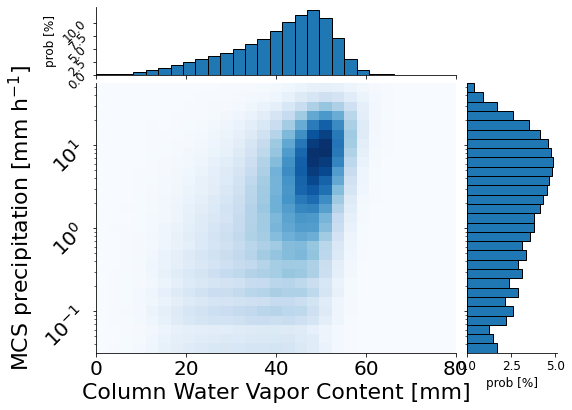

In [14]:
fig = plt.figure( figsize=(8,6) )
font_size = 20
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})
i = np.where( (~np.isnan(cwvc_ERAI)) & (~np.isnan(pmax_ERAI)) )

gs = fig.add_gridspec( 2, 2, width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9,
                     wspace=0.05, hspace=0.05 )
ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot( gs[0,0], sharex=ax )
ax_histy = fig.add_subplot( gs[1,1], sharey=ax )
scatter_hist( cwvc_ERAI[i], pmax_ERAI[i], np.linspace(0,80,30), np.logspace(-1.5,1.75,30), ax, ax_histx, ax_histy )

ax.set_xticks( [0, 20, 40, 60, 80] )
ax_histx.set_ylabel( 'prob [%]', fontsize=12 )
ax_histx.set_yticks( [0, 2.5, 5, 7.5, 10], rotation=45 )
ax_histy.set_xlabel( 'prob [%]', fontsize=12 )
ax_histy.set_xticks( [0, 2.5, 5], rotation=45 )
ax.set_ylabel( 'MCS precipitation [mm h$^{-1}$]' )
ax.set_xlabel( 'Column Water Vapor Content [mm]' )

for a in ax, ax_histx, ax_histy:
    a.spines['top'].set_visible( False )
    a.spines['right'].set_visible( False )
    for t in a.get_yticklabels():
        t.set_rotation(45)

plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-precip-ERAI.pdf', bbox_inches='tight' )
plt.show()

### Joint distribution of CSF and MCS precip accumulation

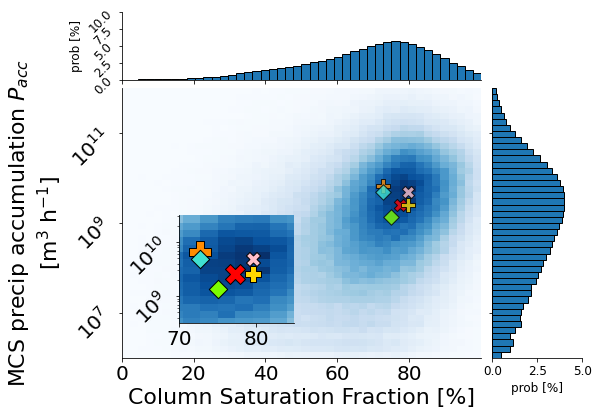

In [20]:
fig = plt.figure( figsize=(8,6) )
font_size = 20
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})
i = np.where( (~np.isnan(csf_ERAI)) & (~np.isnan(pacc_ERAI)) )

gs = fig.add_gridspec( 2, 2, width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9,
                     wspace=0.05, hspace=0.05 )
ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot( gs[0,0], sharex=ax )
ax_histy = fig.add_subplot( gs[1,1], sharey=ax )
xbins = np.linspace(0,100,45)
ybins = np.logspace(6,12,45)
scatter_hist( csf_ERAI[i], pacc_ERAI[i], xbins, ybins, ax, ax_histx, ax_histy )

ax.set_xticks( [0, 20, 40, 60, 80] )
ax_histx.set_ylabel( 'prob [%]', fontsize=12 )
ax_histx.set_yticks( [0, 2.5, 5, 7.5, 10], rotation=45 )
ax_histy.set_xlabel( 'prob [%]', fontsize=12 )
ax_histy.set_xticks( [0, 2.5, 5], rotation=45 )
ax.set_ylabel( 'MCS precip accumulation $P_{acc}$'
              '\n'
              '[m$^3$ h$^{-1}$]' )
ax.set_xlabel( 'Column Saturation Fraction [%]' )

# Inset to see centroids more easily
left, bottom, width, height = [0.2, 0.18, 0.2, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.hist2d( csf_ERAI[i], pacc_ERAI[i], bins=(xbins, ybins), cmap=cm.Blues )
ax2.set_xlim( [70, 85] )
ax2.set_yscale( 'log' )
ax2.set_ylim( [10**8.5, 10**10.5]  )

for a in ax, ax_histx, ax_histy, ax2:
    a.spines['top'].set_visible( False )
    a.spines['right'].set_visible( False )
    for t in a.get_yticklabels():
        t.set_rotation(45)
        
# Where is the center of mass of the joint distribution for young/old/big/small systems? 
# (The cells below must be run for this.)
h_csfpacc = [ h1, h4, h5, h7, h3, h6 ] #h2 - already covered by h4, h6 - already covered by h5
farbe = [ 'red', 'gold', 'darkorange', 'lawngreen', 'pink', 'turquoise' ]
forme = [ 'X', 'P', 'P', 'D', 'X', 'D']
grose = [ 150, 200, 200, 120, 150, 120 ]
increment = [ 250, 40, 250, 50, 50, 50 ]
for histo, f, s, z, ii in zip( h_csfpacc, farbe, forme, grose, increment ):
    l, m = unravel_index( histo[0].argmax(), histo[0].shape )
    #print(l,m)
    ax.scatter( xbins[l], ybins[m], marker=s, color=f, s=z, zorder=10, edgecolor='k', alpha=0.8 )
    ax2.scatter( xbins[l], ybins[m], marker=s, color=f, s=z+ii, zorder=10, edgecolor='k' )
        
plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-pacc-ERAI.pdf', bbox_inches='tight' )
plt.show()

### Joint distribution of CSF and MCS precip accumulation for short- and long-lived systems

In [17]:
i = np.where(lifetime_ERAI <= 10)
csf_ERAI_young = csf_ERAI[i]
pacc_ERAI_young = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_young)) & (~np.isnan(pacc_ERAI_young)) )
h1 = scatter_hist( csf_ERAI_young[i], pacc_ERAI_young[i], xbins, ybins, ax, ax_histx, ax_histy )
print(h1[0].argmax())
print( unravel_index( h1[0].argmax(), h1[0].shape ) )

i = np.where((lifetime_ERAI <= 4) & (lifetime_ERAI > 2))
csf_ERAI_mid = csf_ERAI[i]
pacc_ERAI_mid = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_mid)) & (~np.isnan(pacc_ERAI_mid)) )
h2 = scatter_hist( csf_ERAI_mid[i], pacc_ERAI_mid[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where((lifetime_ERAI > 3))
csf_ERAI_old = csf_ERAI[i]
pacc_ERAI_old = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_old)) & (~np.isnan(pacc_ERAI_old)) )
h3 = scatter_hist( csf_ERAI_old[i], pacc_ERAI_old[i], xbins, ybins, ax, ax_histx, ax_histy )
print(h3[0].argmax())
print( unravel_index( h3[0].argmax(), h3[0].shape ) )

1521
(34, 25)
1567
(35, 27)


### Joint distribution of CSF and MCS precip filtering by morphology

In [2]:
i = np.where(maxrad_ERAI <= 150)
#print(len(i[0]))
csf_ERAI_small = csf_ERAI[i]
pacc_ERAI_small = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_small)) & (~np.isnan(pacc_ERAI_small)) )
h4 = scatter_hist( csf_ERAI_small[i], pacc_ERAI_small[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where(maxrad_ERAI > 400)
#print(len(i[0]))
csf_ERAI_big = csf_ERAI[i]
pacc_ERAI_big = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_big)) & (~np.isnan(pacc_ERAI_big)) )
h5 = scatter_hist( csf_ERAI_big[i], pacc_ERAI_big[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where(minctt_ERAI <= 190)
#print(len(i[0]))
csf_ERAI_deep = csf_ERAI[i]
pacc_ERAI_deep = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_deep)) & (~np.isnan(pacc_ERAI_deep)) )
h6 = scatter_hist( csf_ERAI_deep[i], pacc_ERAI_deep[i], xbins, ybins, ax, ax_histx, ax_histy )

i = np.where(minctt_ERAI > 205)
#print(len(i[0]))
csf_ERAI_shallow = csf_ERAI[i]
pacc_ERAI_shallow = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_shallow)) & (~np.isnan(pacc_ERAI_shallow)) )
h7 = scatter_hist( csf_ERAI_shallow[i], pacc_ERAI_shallow[i], xbins, ybins, ax, ax_histx, ax_histy )

NameError: name 'np' is not defined

## Figure 3 - Binning of CSF and precipitation across percentiles

In [24]:
# exponential fit between CSF and precipitation across percentiles
def monoexp(x, m, a):
    return m * np.exp(a * x)

# fit an exponential to the CSF-Precip relationship and assess goodness-of-fit
# CSF input to the curve_fit is a decimal not a percentage, hence /100.
p0 = [ 1, 11 ]
i = np.where( ~np.isnan(csf_bins) )
params, cv = scipy.optimize.curve_fit( monoexp, csf_bins[i]/100., pmax_vals2[i], p0 )
m, a = params
print( m, a )

# fit an exponential to the CSF-Precip accumulation relationship and assess goodness-of-fit
p0 = [ 1, 11 ]
i = np.where( ~np.isnan(csf_bins) )
params, cv = scipy.optimize.curve_fit( monoexp, csf_bins[i]/100., pacc_vals2[i], p0 )
m2, a2 = params
print( m2, a2 )

squaredDiffs = np.square(pmax_vals2[i] - monoexp(csf_bins[i]/100., m, a))
squaredDiffsFromMean = np.square(pmax_vals2[i] - np.mean(pmax_vals2[i]))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print( rSquared )

0.4458477181948006 3.274897526637655
6449683028.138033 2.0840256848722927
0.9820939337999627


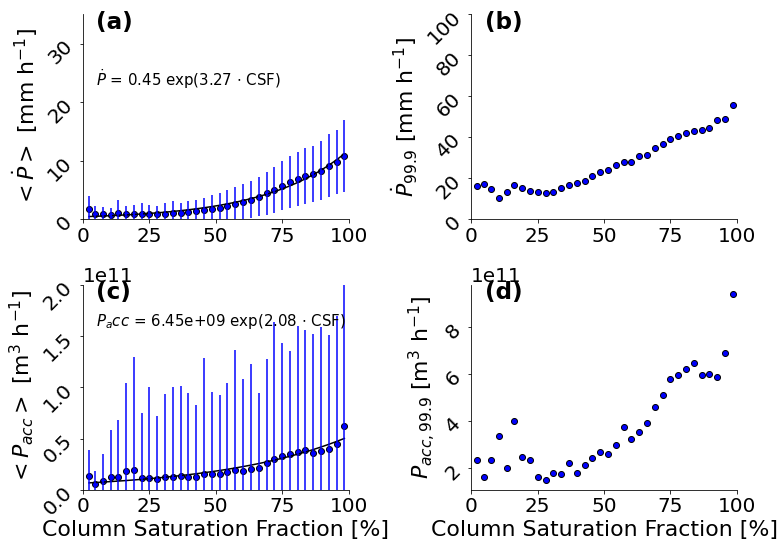

In [31]:
fig, ax = plt.subplots( 2, 2, figsize =(11, 8) )

ylab = [ r'$< \dot{P} >$ [mm h$^{-1}$]', r'$\dot{P}_{99.9}$ [mm h$^{-1}$]', r'$< P_{acc} >$ [m$^3$ h$^{-1}$]',\
             r'$P_{acc, 99.9}$ [m$^3$ h$^{-1}$]' ]
labels = [ '', '' , 'Column Saturation Fraction [%]', 'Column Saturation Fraction [%]' ]
let = [ '(a)', '(b)', '(c)', '(d)' ]
font_size = 20
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, 100] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.93, let[i], transform=axis.transAxes, fontsize=font_size+3, weight='bold' )
    
    if i == 0:
        y = monoexp( csf_bins/100, m, a )
        axis.plot( csf_bins, y, lw=1.5, color='k' )
        axis.scatter( csf_bins, pmax_vals2, color = 'blue', edgecolor='k' )
        axis.errorbar( csf_bins, pmax_vals2, xerr=csf_error/2, yerr=pmax_error2/2, color = 'blue', ls='none' )
        axis.set_ylim([0, 35])
        axis.text( 0.05, 0.65, r'$\dot P$ = {:.2f} exp({:.2f} $\cdot$ CSF)'.format(m,a), transform=axis.transAxes, fontsize=15 )
    elif i == 1:
        axis.scatter( csf_bins, pmax_99_vals2, color = 'blue', edgecolor='k' )
        axis.set_ylim([0, 100])
    elif i == 2:
        y = monoexp( csf_bins/100, m2, a2 )
        axis.plot( csf_bins, y, lw=1.5, color='k' )
        axis.scatter( csf_bins, pacc_vals2, color = 'blue', edgecolor='k' )
        axis.errorbar( csf_bins, pacc_vals2, xerr=csf_error/2, yerr=pacc_error2/2, color = 'blue', ls='none' )
        axis.set_ylim([0, 2*10**11])
        axis.text( 0.05, 0.8, r'$P_acc$ = {:.2e} exp({:.2f} $\cdot$ CSF)'.format(m2,a2), transform=axis.transAxes, fontsize=15 )
    elif i == 3:
        axis.scatter( csf_bins, pacc_99_vals2, color = 'blue', edgecolor='k' )

plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-precip-ERAI-percentiles.pdf', bbox_inches='tight' )
#plt.show()

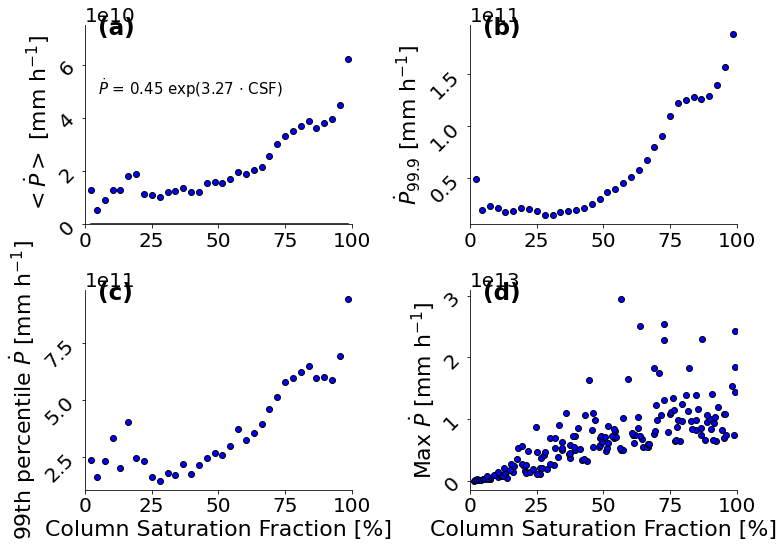

In [16]:
fig, ax = plt.subplots( 2, 2, figsize =(11, 8) )

ylab = [ r'$< \dot{P} >$ [mm h$^{-1}$]', r'$\dot{P}_{99.9}$ [mm h$^{-1}$]', r'99th percentile $\dot{P}$ [mm h$^{-1}$]',\
             r'Max $\dot{P}$ [mm h$^{-1}$]' ]
labels = [ '', '' , 'Column Saturation Fraction [%]', 'Column Saturation Fraction [%]' ]
let = [ '(a)', '(b)', '(c)', '(d)' ]
font_size = 20
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, 100] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.95, let[i], transform=axis.transAxes, fontsize=font_size+3, weight='bold' )
    
    if i == 0:
        y = monoexp( csf_bins/100, m, a )
        axis.plot( csf_bins, y, lw=1.5, color='k' )
        axis.scatter( csf_bins, pacc_vals2, color = 'blue', edgecolor='k' )
        #axis.errorbar( csf_bins, pacc_vals2, xerr=csf_error/2, yerr=pacc_error2/4, color = 'blue', ls='none' )
        axis.set_ylim([0, 0.75*10**11])
        axis.text( 0.05, 0.65, r'$\dot P$ = {:.2f} exp({:.2f} $\cdot$ CSF)'.format(m,a), transform=axis.transAxes, fontsize=15 )
    elif i == 1:
        axis.scatter( csf_bins, pacc_95_vals2, color = 'blue', edgecolor='k' )
        #axis.set_ylim([0, 35])
    elif i == 3:
        axis.scatter( csf_max.flatten(), pacc_max2.flatten(), color = 'blue', edgecolor='k' )
        #axis.set_ylim([0, 200])
    else:
        axis.scatter( csf_bins, pacc_99_vals2, color = 'blue', edgecolor='k' )
        #axis.set_ylim([0, 100])

plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-precip-ERAI-percentiles.pdf', bbox_inches='tight' )
#plt.show()

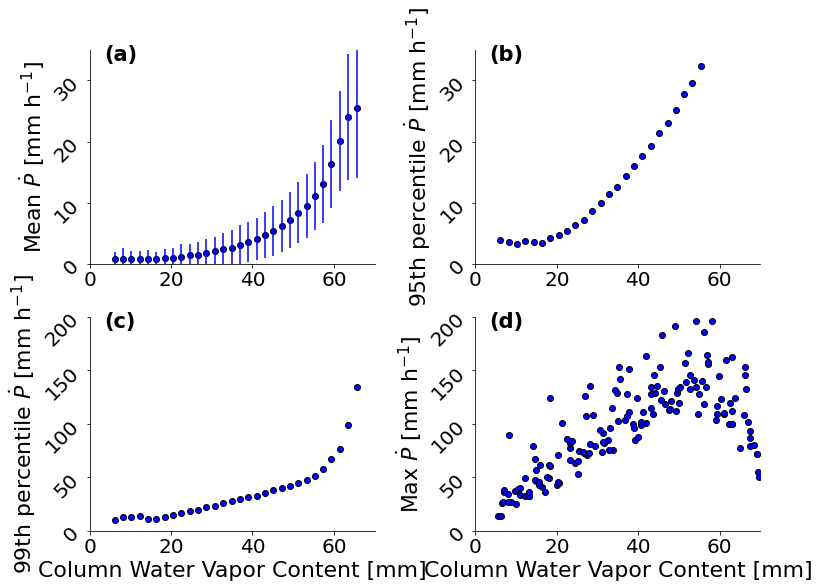

In [24]:
fig, ax = plt.subplots( 2, 2, figsize =(11, 8) )

ylab = [ r'Mean $\dot{P}$ [mm h$^{-1}$]', r'95th percentile $\dot{P}$ [mm h$^{-1}$]', r'99th percentile $\dot{P}$ [mm h$^{-1}$]',\
             r'Max $\dot{P}$ [mm h$^{-1}$]' ]
labels = [ '', '' , 'Column Water Vapor Content [mm]', 'Column Water Vapor Content [mm]' ]
let = [ '(a)', '(b)', '(c)', '(d)' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, 70] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.95, let[i], transform=axis.transAxes, fontsize=font_size+3, weight='bold' )
    
    if i == 0:
        axis.scatter( cwvc_bins, pmax_vals, color='blue', edgecolor='k' )
        axis.errorbar( cwvc_bins, pmax_vals, xerr=cwvc_error/2, yerr=pmax_error/2, color = 'blue', ls='none' )
        axis.set_ylim([0, 35])
    elif i == 1:
        axis.scatter( cwvc_bins, pmax_95_vals, color='blue', edgecolor='k' )
        axis.set_ylim([0, 35])
    elif i == 3:
        axis.scatter( cwvc_max.flatten(), pmax_max.flatten(), color = 'blue', edgecolor='k' )
        axis.set_ylim([0, 200])
    else:
        axis.scatter( cwvc_bins, pmax_99_vals, color='blue', edgecolor='k' )
        axis.set_ylim([0, 200])

plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/cwvc-precip-ERAI-percentiles.pdf', bbox_inches='tight' )
#plt.show()

### Can we look at pickup behavior only for the very longest-lived systems? Is the threshold CSF higher for shorter-lived systems?

In [25]:
# identify indices of short-lived systems
i = np.where(lifetime_ERAI <= 3)
csf_ERAI_young = csf_ERAI[i]
pmax_ERAI_young = pmax_ERAI[i]
print(np.nanmedian(csf_ERAI_young), np.nanmean(csf_ERAI_young))

i = np.where(lifetime_ERAI <= 4)
csf_ERAI_young = csf_ERAI[i]
pmax_ERAI_young = pmax_ERAI[i]
print(np.nanmedian(csf_ERAI_young), np.nanmean(csf_ERAI_young))

i = np.where((lifetime_ERAI) > 4 & (lifetime_ERAI <= 8))
csf_ERAI_old = csf_ERAI[i]
pmax_ERAI_old = pmax_ERAI[i]
print(np.nanmedian(csf_ERAI_old), np.nanmean(csf_ERAI_old))

i = np.where(lifetime_ERAI > 8)
csf_ERAI_old = csf_ERAI[i]
pmax_ERAI_old = pmax_ERAI[i]
print(np.nanmedian(csf_ERAI_old), np.nanmean(csf_ERAI_old))

#i = np.where(lifetime_ERAI > 16)
#csf_ERAI_old = csf_ERAI[i]
#pmax_ERAI_old = pmax_ERAI[i]
#print(np.nanmedian(csf_ERAI_old), np.nanmean(csf_ERAI_old))

# there are not really dramatic shifts to the CSF-precipitation relationship when we filter for lifetime
csf_bins_young, pmax_vals_young, pmax_95_vals_young, pmax_99_vals_young, csf_error_young, pmax_error_young, csf_max_young, pmax_max_young = \
    bin_stat_function( 35, 0, 100, csf_ERAI_young, pmax_ERAI_young, threshold=10 )
csf_bins_old, pmax_vals_old, pmax_95_vals_old, pmax_99_vals_old, csf_error_old, pmax_error_old, csf_max_old, pmax_max_old = \
    bin_stat_function( 35, 0, 100, csf_ERAI_old, pmax_ERAI_old, threshold=10 )

73.7321901554974 72.1597906166542
73.57682459456592 71.98370325363211
72.09697195423023 70.21310787626841
69.75769500939109 67.30969586316115


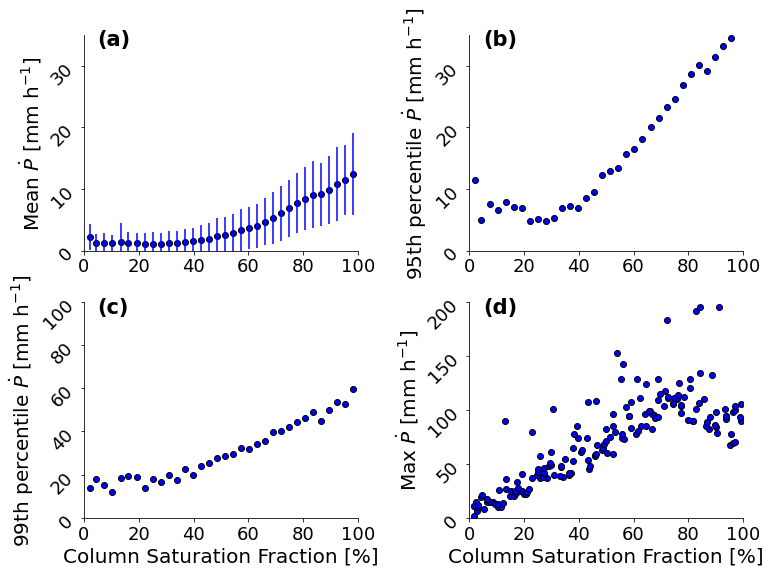

In [27]:
fig, ax = plt.subplots( 2, 2, figsize =(11, 8) )

ylab = [ r'Mean $\dot{P}$ [mm h$^{-1}$]', r'95th percentile $\dot{P}$ [mm h$^{-1}$]', r'99th percentile $\dot{P}$ [mm h$^{-1}$]',\
             r'Max $\dot{P}$ [mm h$^{-1}$]' ]
labels = [ '', '' , 'Column Saturation Fraction [%]', 'Column Saturation Fraction [%]' ]
let = [ '(a)', '(b)', '(c)', '(d)' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, 100] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.95, let[i], transform=axis.transAxes, fontsize=font_size+3, weight='bold' )
    
    if i == 0:
        #y = monoexp(csf_bins_young/100, m, a, b)
        #axis.plot( csf_bins_young, y, lw=0.75, color='k' )
        axis.scatter( csf_bins_old, pmax_vals_old, color = 'blue', edgecolor='k' )
        axis.errorbar( csf_bins_old, pmax_vals_old, xerr=csf_error_old/2, yerr=pmax_error_old/2, color = 'blue', ls='none' )
        axis.set_ylim([0, 35])
        #axis.text( 0.05, 0.65, r'$\dot P$ = 0.45 exp({:.2f} $\cdot$ CSF)'.format(a), transform=axis.transAxes, fontsize=15 )
    elif i == 1:
        axis.scatter( csf_bins_old, pmax_95_vals_old, color = 'blue', edgecolor='k' )
        axis.set_ylim([0, 35])
    elif i == 3:
        axis.scatter( csf_max_old.flatten(), pmax_max_old.flatten(), color = 'blue', edgecolor='k' )
        axis.set_ylim([0, 200])
    else:
        axis.scatter( csf_bins_old, pmax_99_vals_old, color = 'blue', edgecolor='k' )
        axis.set_ylim([0, 100])

plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-precip-ERAI.pdf', bbox_inches='tight' )
#plt.show()

## Figure 5 - Saturation deficit-CAPE relationship across percentiles

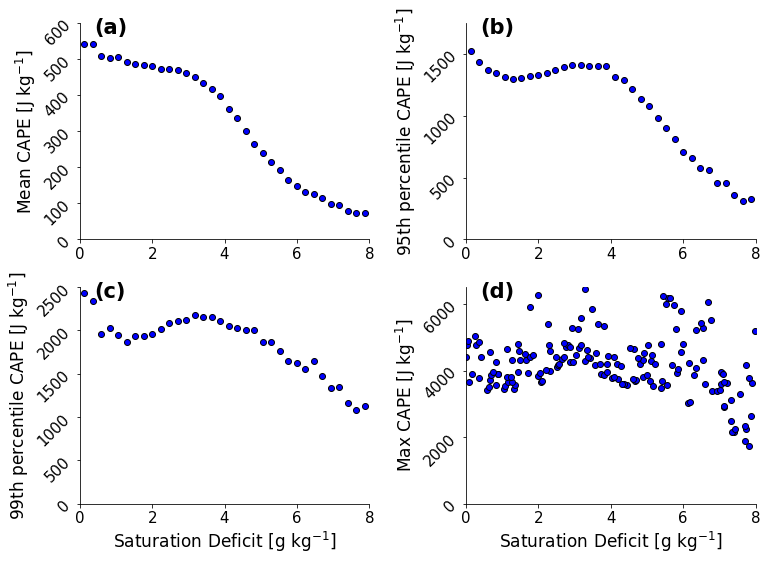

In [50]:
fig, ax = plt.subplots( 2, 2, figsize =(11, 8) )

ylab = [ r'Mean CAPE [J kg$^{-1}$]', r'95th percentile CAPE [J kg$^{-1}$]', r'99th percentile CAPE [J kg$^{-1}$]',\
             r'Max CAPE [J kg$^{-1}$]' ]
labels = [ '', '', r'Saturation Deficit [g kg$^{-1}$]', r'Saturation Deficit [g kg$^{-1}$]' ]
let = [ '(a)', '(b)', '(c)', '(d)' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, 8] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    #axis.get_xticks().set_rotation(45)
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.95, let[i], transform=axis.transAxes, fontsize=font_size+3, weight='bold' )
    
    if i == 0:
        axis.scatter( sd_bins, cape_vals, color='blue', edgecolor='k' )
        axis.set_ylim([0, 600])
    elif i == 1:
        axis.scatter( sd_bins, cape_95_vals, color = 'blue', edgecolor='k' )
        axis.set_ylim([0, 1750])
    elif i == 2:
        axis.scatter( sd_bins, cape_99_vals, color = 'blue', edgecolor='k' )
        axis.set_ylim([0, 2500])
    else:
        cape_max_flat = cape_max.flatten()
        sd_max_flat = sd_max.flatten()
        #print(len(np.where(cape_max_flat>=6500)[0])) # how many outliers?
        sd_max_flat = sd_max_flat[cape_max_flat < 6500] # removing 6 outliers
        cape_max_flat = cape_max_flat[cape_max_flat < 6500] # removing 6 outliers
        axis.scatter( sd_max_flat, cape_max_flat, color = 'blue', edgecolor='k' )
        axis.set_ylim([0, 6510])

plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/sd-cape-ERAI-percentiles.pdf', bbox_inches='tight' )
#plt.show()

### Does the saturation deficit-CAPE relationship strengthen when we use preceding values of CAPE (not simultaneous with rainfall)?

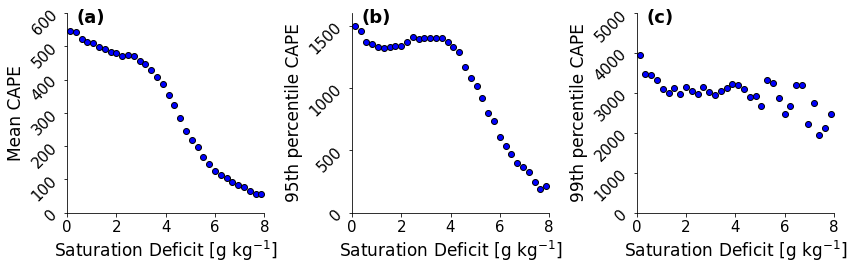

In [104]:
fig, ax = plt.subplots( 1, 3, figsize =(12, 4) )

ylab = [ r'Mean CAPE', r'95th percentile CAPE', r'99th percentile CAPE',\
             r'Max CAPE' ]
labels = [ r'Saturation Deficit [g kg$^{-1}$]', r'Saturation Deficit [g kg$^{-1}$]',
          r'Saturation Deficit [g kg$^{-1}$]' ]
let = [ '(a)', '(b)', '(c)' ]
font_size = 15
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, 8] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    #axis.get_xticks().set_rotation(45)
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.95, let[i], transform=axis.transAxes, fontsize=font_size+3, weight='bold' )
    
    if i == 0:
        axis.scatter( sdpre_bins, capepre_vals2, color='blue', edgecolor='k' )
        axis.set_ylim([0, 600])
    elif i == 1:
        axis.scatter( sdpre_bins, capepre_95_vals2, color = 'blue', edgecolor='k' )
        axis.set_ylim([0, 1600])
    else:
        axis.scatter( sdpre_bins, capepre_99_vals2, color = 'blue', edgecolor='k' )
        axis.set_ylim([0, 5000])

plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/sdpre-capepre-ERAI.pdf', bbox_inches='tight' )
#plt.show()

### Does the saturation deficit-CAPE relationship strengthen when we use preceding values of both SD and CAPE (not simultaneous with rainfall)?

## Figure 8 -  Pressure velocity-CAPE conversion

In [9]:
# Read in the vertical velocities
omega_array = nc_open_compile(file_years,"omega",'stack')
# Extract the value around 500 hPa
omega_ERAI_mid = omega_array[:,14]

# Filter for negative values of omega (ascent rates)
omega_ERAI_mid_n, cape_array_n = negative_vals( omega_ERAI_mid, cape_array )
cape_bins_ascent, ascent_bins, ascent_95_bins, ascent_99_bins, cape_error_ascent, ascent_error, cape_max_ascent, ascent_max = \
    bin_stat_function( 50, 0, 4500, cape_array_n, omega_ERAI_mid_n, threshold=5 ) 

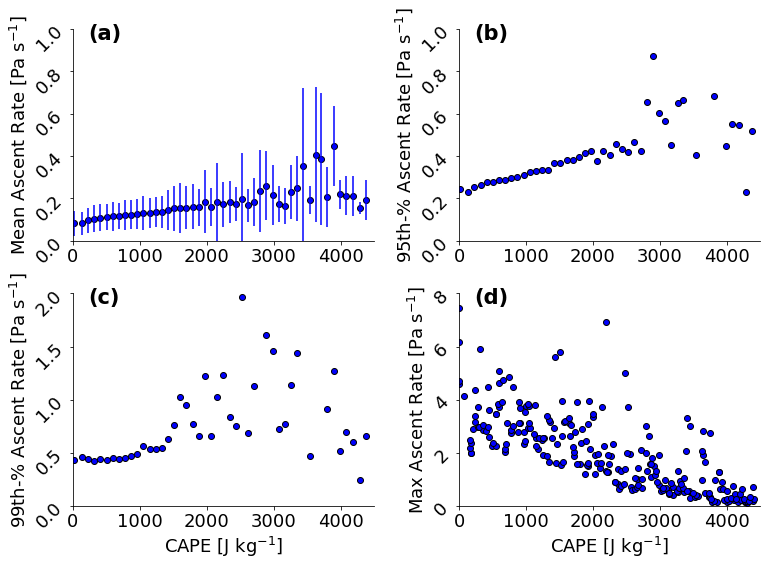

In [20]:
fig, ax = plt.subplots( 2, 2, figsize =(11, 8) )

ylab = [ r'Mean Ascent Rate [Pa s$^{-1}$]', '95th-% Ascent Rate [Pa s$^{-1}$]', r'99th-% Ascent Rate [Pa s$^{-1}$]',\
             r'Max Ascent Rate [Pa s$^{-1}$]' ]
labels = [ '', '' , r'CAPE [J kg$^{-1}$]', 'CAPE [J kg$^{-1}$]' ]
let = [ '(a)', '(b)', '(c)', '(d)' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, 4500] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.95, let[i], transform=axis.transAxes, fontsize=font_size+3, weight='bold' )
    
    if i == 0:
        axis.scatter( cape_bins_ascent, ascent_bins, color = 'blue', edgecolor='black' )
        axis.errorbar( cape_bins_ascent, ascent_bins, xerr=cape_error_ascent/2, yerr=ascent_error/2, color = 'blue', ls='none' )
        axis.set_ylim([0, 1])
    elif i == 1:
        axis.scatter( cape_bins_ascent, ascent_95_bins, color='blue', edgecolor='black' )
        axis.set_ylim([0, 1])
    elif i == 3:
        axis.scatter( cape_max_ascent.flatten(), ascent_max.flatten(), color='blue', edgecolor='black' )
        axis.set_ylim([0, 8])
    else:
        axis.scatter( cape_bins_ascent, ascent_99_bins,color='blue', edgecolor='black')
        axis.set_ylim([0, 2])

plt.tight_layout()
fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/ascent-CAPE-ERAI.pdf', bbox_inches='tight' )
plt.show() 

### Same exercise as above but for descent rates (positive omega) not ascent rates.

In [19]:
# Extract the value around 500 hPa
omega_ERAI_mid = omega_array[:,14]

# Filter for positive values of omega (descent rates)
omega_ERAI_mid_p, cape_array_p = positive_vals( omega_ERAI_mid, cape_array )
cape_bins_descent, descent_bins, descent_95_bins, descent_99_bins, cape_error_descent, descent_error, cape_max_descent, descent_max = \
    bin_stat_function( 50, 0, 4500, cape_array_p, omega_ERAI_mid_p, threshold=5 ) 

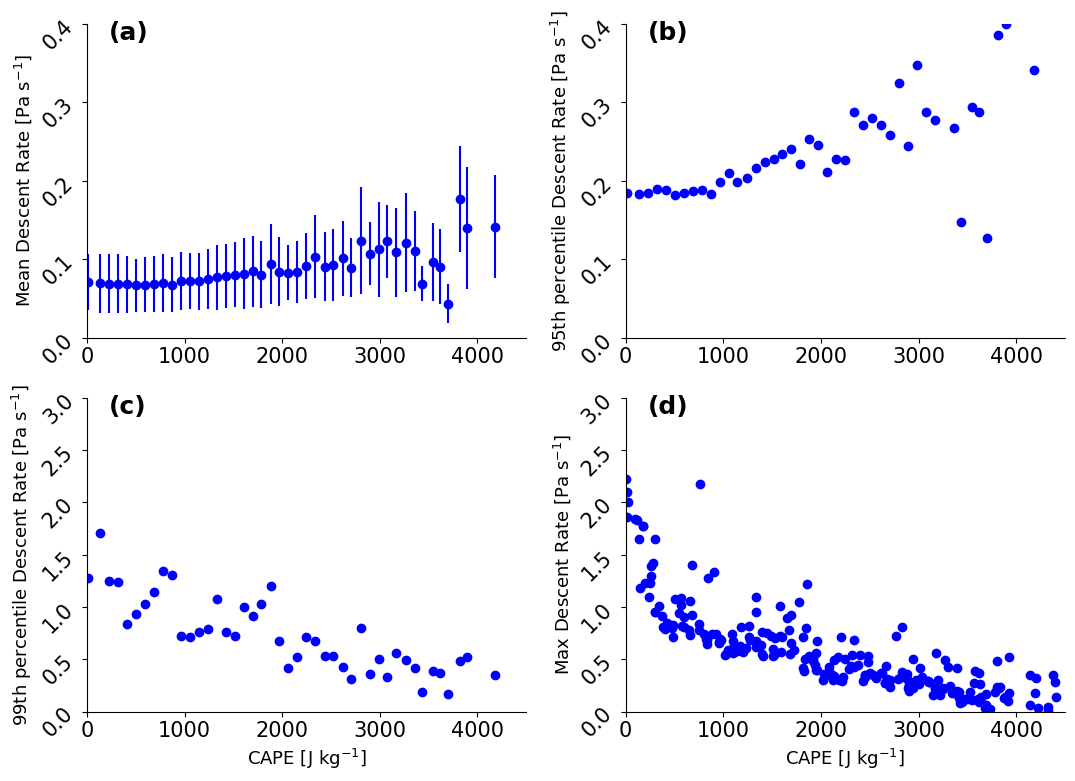

In [21]:
fig, ax = plt.subplots( 2, 2, figsize =(11, 8) )

ylab = [ r'Mean Descent Rate [Pa s$^{-1}$]', '95th percentile Descent Rate [Pa s$^{-1}$]', r'99th percentile Descent Rate [Pa s$^{-1}$]',\
             r'Max Descent Rate [Pa s$^{-1}$]' ]
labels = [ '', '' , r'CAPE [J kg$^{-1}$]', 'CAPE [J kg$^{-1}$]' ]
let = [ '(a)', '(b)', '(c)', '(d)' ]
font_size = 15
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size-2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, 4500] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.95, let[i], transform=axis.transAxes, fontsize=font_size+3, weight='bold' )
    
    if i == 0:
        axis.scatter( cape_bins_descent, descent_bins, color = 'blue')
        axis.errorbar( cape_bins_descent, descent_bins, xerr=cape_error_descent/2, yerr=descent_error/2, color = 'blue', ls='none' )
        axis.set_ylim([0, 0.4]) # Descent rate range is much smaller than ascent rate range!!
    elif i == 1:
        axis.scatter( cape_bins_descent, descent_95_bins, color = 'blue', edgecolor='black')
        axis.set_ylim([0, 0.4])
    elif i == 3:
        axis.scatter( cape_max_descent.flatten(), descent_max.flatten(), color = 'blue', edgecolor='black' )
        axis.set_ylim([0, 3])
    else:
        axis.scatter( cape_bins_descent, descent_99_bins,color='blue', edgecolor='black')
        axis.set_ylim([0, 3])

plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/descent-CAPE-ERAI.pdf', bbox_inches='tight' )
#plt.show() 

### How does omega-CAPE conversion change when we use preceding values of CAPE (not simultaneous with ascent)?

In [24]:
# Extract the value around 500 hPa
omega_ERAI_mid = omega_array[:,14]

# Filter for negative values of omega (ascent rates)
omega_ERAI_mid_n, capepre6_array_n = negative_vals( omega_ERAI_mid, capepre6_array )
capepre6_bins_ascent, ascent_bins, ascent_95_bins, ascent_99_bins, capepre6_error_ascent, ascent_error, capepre6_max_ascent, \
    ascent_max = bin_stat_function( 50, 0, 4500, capepre6_array_n, omega_ERAI_mid_n, threshold=5 ) 

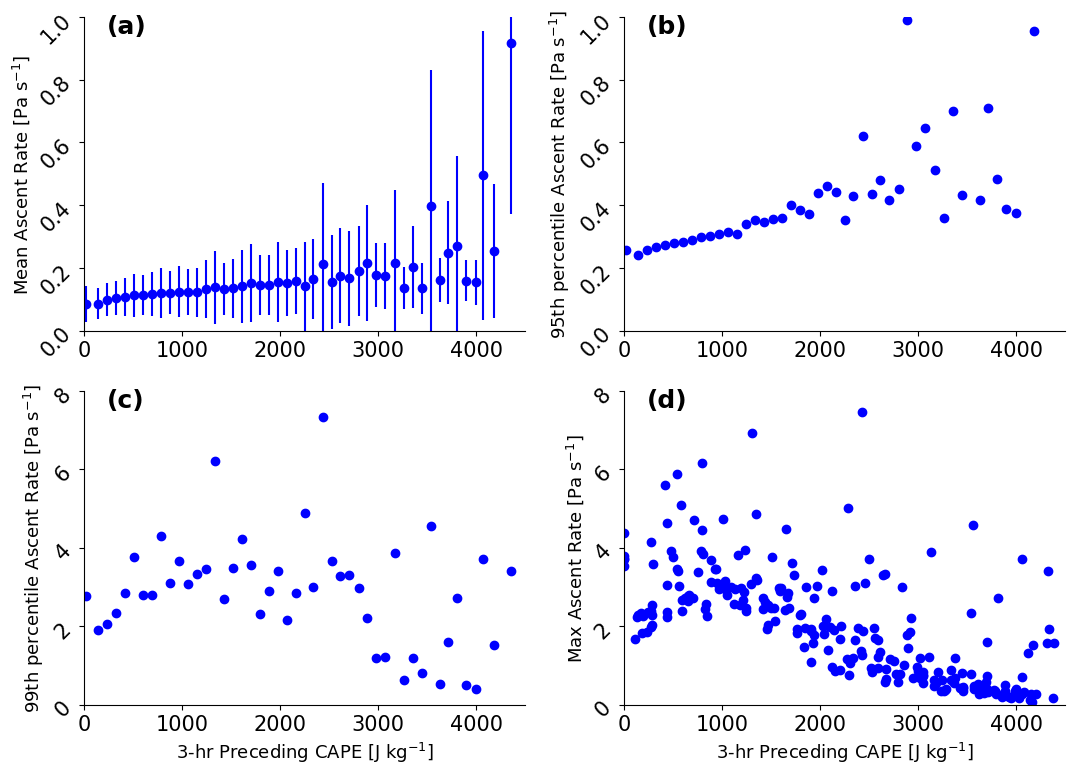

In [26]:
fig, ax = plt.subplots( 2, 2, figsize =(11, 8) )

ylab = [ r'Mean Ascent Rate [Pa s$^{-1}$]', '95th percentile Ascent Rate [Pa s$^{-1}$]', r'99th percentile Ascent Rate [Pa s$^{-1}$]',\
             r'Max Ascent Rate [Pa s$^{-1}$]' ]
labels = [ '', '' , r'3-hr Preceding CAPE [J kg$^{-1}$]', '3-hr Preceding CAPE [J kg$^{-1}$]' ]
let = [ '(a)', '(b)', '(c)', '(d)' ]
font_size = 15
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size-2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, 4500] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.95, let[i], transform=axis.transAxes, fontsize=font_size+3, weight='bold' )
    
    if i == 0:
        axis.scatter( capepre_bins_ascent, ascent_bins, color = 'blue')
        axis.errorbar( capepre_bins_ascent, ascent_bins, xerr=capepre_error_ascent/2, yerr=ascent_error/2, color = 'blue', ls='none' )
        axis.set_ylim([0, 1])
    elif i == 1:
        axis.scatter( capepre_bins_ascent, ascent_95_bins, color = 'blue')
        axis.set_ylim([0, 1])
    elif i == 3:
        axis.scatter( capepre_max_ascent.flatten(), ascent_max.flatten(), color = 'blue' )
        axis.set_ylim([0, 8])
    else:
        axis.scatter( capepre_bins_ascent, ascent_99_bins,color = 'blue')
        axis.set_ylim([0, 8])

plt.tight_layout()
fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/ascent-CAPEpre-ERAI.pdf', bbox_inches='tight' )
#plt.show() 

## Figure 11 - precip efficiency from integrated cond rate scaling

In [16]:
# Calculate the gradient with respect to pressure of the saturation vapor mixing ratio
p_ERAI = (xr.open_dataset(file_years[0])).pressure.data*100. # converting hPa -> Pa
dqvsat_dp_ERAI = np.gradient( qvsat_ERAI, p_ERAI, axis=1 )
print( qvsat_ERAI[100] )
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print( p_ERAI )
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print( dqvsat_dp_ERAI[100] )

# Multiply the gradient with respect to pressure by pressure velocity
omega_array = nc_open_compile(file_years,"omega",'stack')
omega_ERAI = positive_to_nan(omega_array)[tropical_indx]
integrand = 100*omega_ERAI*dqvsat_dp_ERAI/g

# Integrate the condensation rate over the pressures
cond_rate_ERAI = np.trapz(x=p_ERAI,y=-1.*integrand)
print( np.nanmin(cond_rate_ERAI), np.nanmedian(cond_rate_ERAI), np.nanmean(cond_rate_ERAI), np.nanmax(cond_rate_ERAI) )
peff_ERAI = pmax_ERAI / 3600 / cond_rate_ERAI
print( np.nanmin(peff_ERAI), np.nanmedian(peff_ERAI), np.nanmax(peff_ERAI) )

[1.34898528e-05 2.30250326e-05 3.57284688e-05 4.69980634e-05
 7.58480914e-05 1.40050223e-04 2.66962904e-04 4.44740772e-04
 7.05556283e-04 1.09254636e-03 1.66705591e-03 2.39760405e-03
 3.17131059e-03 4.15229334e-03 5.44210507e-03 6.39579555e-03
 7.35468785e-03 8.38152320e-03 9.46576204e-03 1.05663157e-02
 1.13615767e-02 1.21839845e-02 9.78217224e-03 6.87717239e-03
 7.46137496e-03 8.14000080e-03 9.00645758e-03 9.79422957e-03
 1.05697265e-02 1.12453042e-02 1.18228227e-02 1.22957996e-02]
~~~~~~~~~~~~~~~~~~~~~~~~~~~
[ 12261.37   14290.17   16508.86   18914.66   21502.51   24265.23
  27205.93   30321.74   33604.39   37040.72   40613.28   44300.86
  48079.07   51920.93   55797.34   59677.742  63530.6    67324.03
  71026.266  74606.34   78034.555  81283.03   84326.34   87142.03
  89711.18   92018.93   94055.11   95814.77   97298.68   98513.99
  99474.72  100202.36 ]
~~~~~~~~~~~~~~~~~~~~~~~~~~~
[ 4.69991163e-09  5.18985131e-09  5.22606178e-09  7.79847845e-09
  1.69959248e-08  3.28872367e-08  4.

In [22]:
# Thermodynamic parameters - how strong is correlation with these?
t2m_array = nc_open_compile(file_years,"t2m")
t2m_ERAI = negative_to_nan(t2m_array)[tropical_indx]
dpt_array = nc_open_compile(file_years,"dpt")
dpt_ERAI = negative_to_nan(dpt_array)[tropical_indx]
sst_array = nc_open_compile(file_years,"sst")
sst_ERAI = negative_to_nan(sst_array)[tropical_indx]

In [30]:
# Storm morphology parameters - how strong is correlation with these?
rad_array = nc_open_compile(file_years,"rad")
rad_ERAI = negative_to_nan(rad_array)[tropical_indx]
ctt_array = nc_open_compile(file_years,"ctt")
ctt_ERAI = negative_to_nan(ctt_array)[tropical_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_indx]
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_indx]

# Integrated amounts of cloud condensate - how strong is correlation with these?
qi_array = nc_open_compile(file_years,"qi","stack")
qi_ERAI = negative_to_nan(qi_array)[tropical_indx]
IWP_ERAI = np.cumsum( rho_water*qi_ERAI, axis=1 )*1000 # [g m-2]
IWP_ERAI = IWP_ERAI[:,-1]
qc_array = nc_open_compile(file_years,"qc","stack")
qc_ERAI = negative_to_nan(qc_array)[tropical_indx]
LWP_ERAI = np.cumsum( rho_water*qc_ERAI, axis=1 )*1000 # [g m-2]
LWP_ERAI = LWP_ERAI[:,-1]

# CAPE and integrated mass flux - how strong is correlation with these?
cape_array = nc_open_compile(file_years,"cape")
cape_ERAI = negative_to_nan(cape_array)[tropical_indx]
capepre_array = nc_open_compile(file_years,"capepre")
capepre_ERAI = negative_to_nan(capepre_array)[tropical_indx]
capepre6_array = nc_open_compile(file_years,"capepre6")
capepre6_ERAI = negative_to_nan(capepre6_array)[tropical_indx]
omega_array = nc_open_compile(file_years,"omega","stack")
omega_ERAI = positive_to_nan(omega_array)[tropical_indx]
#omegaint_ERAI = np.cumsum( rho*w_ERAI, axis=1 )*1000 # [g m-2]
#print(omegaint_ERAI.shape)
#omegaint_ERAI = omegaint_ERAI[:,-1]
#print(omegaint_ERAI.shape)

In [31]:
# Filter for the correlations below
cape_ERAI = cape_ERAI[peff_ERAI >= 0]
capepre_ERAI = capepre_ERAI[peff_ERAI >= 0]
capepre6_ERAI = capepre6_ERAI[peff_ERAI >= 0]
rad_ERAI = rad_ERAI[peff_ERAI >= 0]
ctt_ERAI = ctt_ERAI[peff_ERAI >= 0]
maxrad_ERAI = maxrad_ERAI[peff_ERAI >= 0]
minctt_ERAI = minctt_ERAI[peff_ERAI >= 0]
IWP_ERAI_2 = IWP_ERAI[peff_ERAI >= 0]

In [32]:
omega_ERA_2 = omega_ERAI[peff_ERAI>=0,:]
#wint_ERAI = wint_ERAI[peff_ERAI >= 0]
LWP_ERAI_2 = LWP_ERAI[peff_ERAI >= 0]
lifetime_ERAI = lifetime_ERAI[peff_ERAI >= 0]
t2m_ERAI = t2m_ERAI[peff_ERAI >= 0]
dpt_ERAI = dpt_ERAI[peff_ERAI >= 0]
sst_ERAI = sst_ERAI[peff_ERAI >= 0]

pmax_ERAI_2 = pmax_ERAI[peff_ERAI >= 0]
peff_ERAI = peff_ERAI[peff_ERAI >= 0]

In [33]:
print('Correlation of precip efficiency with storm morphology parameters')
print( ma.corrcoef(rad_ERAI, peff_ERAI)[0,1] )
print( ma.corrcoef(maxrad_ERAI, peff_ERAI)[0,1] )
print( ma.corrcoef(ctt_ERAI, peff_ERAI)[0,1] )
print( ma.corrcoef(minctt_ERAI, peff_ERAI)[0,1] )
print( ma.corrcoef(lifetime_ERAI, peff_ERAI)[0,1] )
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
#print('Correlation of precip efficiency with LWP versus IWP')
#print( np.corrcoef(LWP_ERAI_2[~np.isnan(LWP_ERAI_2)], peff_ERAI[~np.isnan(LWP_ERAI_2)])[0,1] )
#print( np.corrcoef(IWP_ERAI_2[~np.isnan(IWP_ERAI_2)], peff_ERAI[~np.isnan(IWP_ERAI_2)])[0,1] )
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with various surface temperatures')
print( np.corrcoef(t2m_ERAI, peff_ERAI)[0,1] )
print( np.corrcoef(sst_ERAI[~np.isnan(sst_ERAI)], peff_ERAI[~np.isnan(sst_ERAI)])[0,1] )
print( np.corrcoef(dpt_ERAI, peff_ERAI)[0,1] )
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with CAPE, integrated mass flux, and w')
print( np.corrcoef(cape_ERAI[~np.isnan(cape_ERAI)], peff_ERAI[~np.isnan(cape_ERAI)])[0,1] )
print( np.corrcoef(capepre_ERAI[~np.isnan(capepre_ERAI)], peff_ERAI[~np.isnan(capepre_ERAI)])[0,1] )
print( np.corrcoef(capepre6_ERAI[~np.isnan(capepre6_ERAI)], peff_ERAI[~np.isnan(capepre6_ERAI)])[0,1] )
#print( np.corrcoef(wint_ERAI, peff_ERAI)[0,1] )
#for i in np.arange(w_ERA_2.shape[1]):
#    print( np.corrcoef(w_ERA_2[:,i], peff_ERAI)[0,1] )

Correlation of precip efficiency with storm morphology parameters
0.1968143373461888
0.06898270584128938
0.050381237784257425
-0.03981219283639907
0.04364222299217337
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip efficiency with various surface temperatures
-0.020787513017533208
0.01180654966924733
0.06400188672158702
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip efficiency with CAPE, integrated mass flux, and w
0.02420648209481083
0.01597073434982182
0.01245603866853693


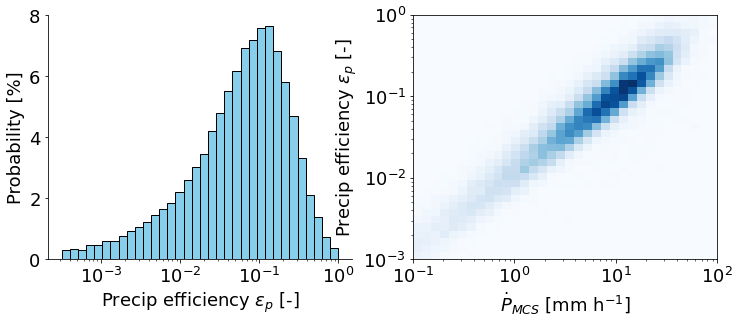

In [42]:
fs = 18
fig, ax = plt.subplots( 1, 2, figsize =(12, 4.5) )

wgts = np.ones_like( peff_ERAI )/float( len( peff_ERAI ) )*100
ax[0].hist( peff_ERAI, bins=np.logspace(-3.5, 0, 35), weights=wgts, color='skyblue', edgecolor='black' )
ax[0].set_ylabel( 'Probability [%]', fontsize=fs )
ax[0].set_xlabel( r'Precip efficiency $\varepsilon_p$ [-]', fontsize=fs )
ax[0].set_xscale( 'log' )
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[1].hist2d( pmax_ERAI_2, peff_ERAI, bins=[ np.logspace(-1,2,35), np.logspace(-3,0,35) ], cmap=plt.cm.Blues )
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'Precip efficiency $\varepsilon_p$ [-]', fontsize=fs)
ax[1].set_xlabel(r'$\dot{P}_{MCS}$ [mm h$^{-1}$]', fontsize=fs)

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/precipeff-ERAI.pdf', bbox_inches='tight' )
plt.show()